In [1]:
from __future__ import annotations
from collections.abc import Callable
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.figure import Figure
from matplotlib.pyplot import Axes
from oscar import Landscape
import sys
sys.path.append('..')
from surface_erasure_decoding import *
from IPython.display import clear_output
from oscar import Landscape
import numpy as np
from collections.abc import Sequence
from oscar import CSReconstructor

from __future__ import annotations
from collections.abc import Sequence
from oscar import CustomExecutor

In [52]:
def generate_bool_array(tot, choose):
    array = np.zeros(tot, dtype=bool)
    indices = np.random.choice(tot, choose, replace=False)
    assert len(indices) == choose
    array[indices] = True
    return array

def get_weight(num_dice_e,num_dice_p,num_e_flipped,num_p_flipped,p_e,p_p):
    # Calculate binomial coefficients
    binom_e = math.comb(num_dice_e, num_e_flipped)
    binom_p = math.comb(num_dice_p, num_p_flipped)
    
    prob_e = (p_e ** num_e_flipped) * ((1 - p_e) ** (num_dice_e - num_e_flipped))
    prob_p = (p_p ** num_p_flipped) * ((1 - p_p) ** (num_dice_p - num_p_flipped))
    
    # Calculate the weight
    weight = binom_e * prob_e * binom_p * prob_p
    
    return weight

shots = 50
d = 5

p_e=0.005
p_p=0.0005
after_cz_error_model = get_2q_error_model(p_e=p_e,
                                        p_p=p_p)
builder = easure_circ_builder(rounds = d,
                                distance= d,
                                after_cz_error_model=after_cz_error_model,
                                measurement_error=0
                                )
builder.generate_helper()
builder.gen_dummy_circuit()

# Step-1 get tot_e, tot_p
non_trivial_gate_error_models = [attr_value for attr_name, attr_value in vars(builder).items() if isinstance(attr_value, GateErrorModel) and not  attr_value.trivial]
assert len(non_trivial_gate_error_models) == 1

tot_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].dummy_generator.num_qubit_called
tot_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].dummy_generator.num_qubit_called

num_qubit_per_dice_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].deterministic_generator.num_qubit_per_dice
num_qubit_per_dice_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].deterministic_generator.num_qubit_per_dice

num_dice_e = int(tot_e/num_qubit_per_dice_e)
num_dice_p = int(tot_p/num_qubit_per_dice_p)

builder.gen_erasure_conversion_circuit()
erasure_circ_next_ancilla_qubit_index = builder.next_ancilla_qubit_index_in_list[0]
converter = builder.erasure_circuit.compile_m2d_converter()

num_dice_e, num_dice_p

(800, 400)

In [53]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LogNorm

# Define the ranges for num_e_flipped and num_p_flipped
# num_e_flipped_range = np.arange(0, 200,1)
# num_p_flipped_range = np.arange(0, 40, 1)
num_e_flipped_range = np.arange(0, num_dice_e,1)
num_p_flipped_range = np.arange(0, num_dice_p, 1)
 
# Initialize the weight matrix
weights = np.zeros((len(num_e_flipped_range), len(num_p_flipped_range)))

# Calculate weights for each combination of num_e_flipped and num_p_flipped
for i, num_e_flipped in enumerate(tqdm(num_e_flipped_range)):
    for j, num_p_flipped in enumerate(num_p_flipped_range):
        weights[i, j] = get_weight(num_dice_e, num_dice_p, num_e_flipped, num_p_flipped, p_e, p_p)


100%|██████████| 800/800 [00:18<00:00, 42.83it/s] 


In [54]:
p_tolerance = 1e-13
flattened_weights = weights.flatten()
sorted_weights = np.sort(flattened_weights)#[::-1]
cumulative_sum = np.cumsum(sorted_weights)
cumulative_prob = cumulative_sum / cumulative_sum[-1]
cutoff_index = np.searchsorted(cumulative_prob, p_tolerance)
cutoff_value = sorted_weights[cutoff_index] if cutoff_index < len(sorted_weights) else sorted_weights[-1]


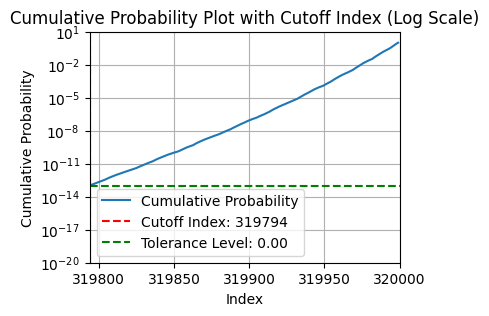

In [55]:

# Plotting
plt.figure(figsize=(4, 3))
plt.plot(cumulative_prob, label='Cumulative Probability')

# Highlight the cutoff point
plt.axvline(x=cutoff_index, color='r', linestyle='--', label=f'Cutoff Index: {cutoff_index}')
plt.axhline(y=p_tolerance, color='g', linestyle='--', label=f'Tolerance Level: {p_tolerance:.2f}')

plt.xlim(xmin  = cutoff_index,xmax = len(sorted_weights))
plt.ylim(1e-20,1e1)
plt.yscale('log') 
plt.xlabel('Index')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Plot with Cutoff Index (Log Scale)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_83424/744213115.py:10: UserWarning: Log scale: values of z <= 0 have been masked
  contour_set = plt.contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
/tmp/ipykernel_83424/744213115.py:12: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_path = contour_set.collections[0].get_paths()[0]


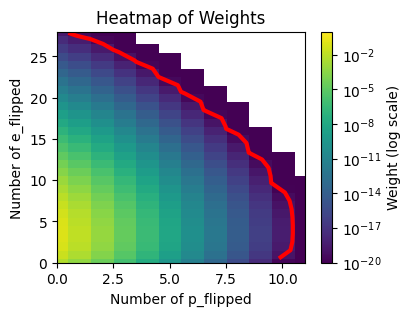

In [56]:

# Create the heatmap
plt.figure(figsize=(4, 3))
plt.imshow(weights, norm=LogNorm(vmin=1e-20,vmax = 1), origin='upper', cmap='viridis', aspect='auto')
plt.colorbar(label='Weight (log scale)')
plt.xlabel('Number of p_flipped')
plt.ylabel('Number of e_flipped')
plt.title('Heatmap of Weights')


contour_set = plt.contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
# Extract the path of the contour at level v
contour_path = contour_set.collections[0].get_paths()[0]

# Get the coordinates of the contour line
contour_coords = contour_path.vertices
x_coords = contour_coords[:, 0]
y_coords = contour_coords[:, 1]


x_min = np.floor(x_coords.min()).astype(int)
x_max = np.ceil(x_coords.max()).astype(int)
y_min = np.floor(y_coords.min()).astype(int)
y_max = np.ceil(y_coords.max()).astype(int)

# Set xlim and ylim using the min and max values
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel('Number of p_flipped')
plt.ylabel('Number of e_flipped')
plt.title('Heatmap of Weights')

plt.show()

In [57]:


def f(params: Sequence[float]) -> float:
    num_p_flipped = int(params[0])
    num_e_flipped = int(params[1])

    shots = 200
    num_errors = 0
    for i in range(shots):

        e_dice_sample = generate_bool_array(num_dice_e, num_e_flipped)
        p_dice_sample = generate_bool_array(num_dice_p, num_p_flipped)

        non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].next_dice_index_in_list = [0]
        non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].next_dice_index_in_list = [0]

        non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].single_dice_sample = e_dice_sample
        non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].single_dice_sample = p_dice_sample

        builder.deterministic_circuit = stim.Circuit()
        builder.gen_circuit(builder.deterministic_circuit,mode='deterministic')
        builder.deterministic_circuit.append("MZ", 
                                    np.arange(2*(builder.distance+1)**2, erasure_circ_next_ancilla_qubit_index, dtype=int)
                                    )  # Measure the virtual erasure ancilla qubits
        
        sampler = builder.deterministic_circuit.compile_sampler()
        meas_samples = sampler.sample(shots=1)
        det_samples, actual_obs_chunk = converter.convert(measurements=meas_samples,
                                                                separate_observables=True)
        
        predicted  = builder.decode_by_generate_new_circ(det_samples[0],'S',meas_samples[0])
        num_errors += actual_obs_chunk[0][0] != predicted
        
    return np.log10(num_errors/shots)


In [58]:

resolution = [x_max-x_min+1 , y_max-y_min+1]
bounds = [(x_min, x_max), (y_min, y_max)]
landscape = Landscape(resolution, bounds)


custom_executor = CustomExecutor(f)

In [59]:
_ = landscape.sample_and_run(custom_executor, sampling_fraction=1 / 10, rng=42)

looping:   6%|▌         | 2/35 [00:28<07:53, 14.35s/it]/tmp/ipykernel_83424/1280192403.py:32: RuntimeWarning: divide by zero encountered in log10
  return np.log10(num_errors/shots)
looping:  97%|█████████▋| 34/35 [07:55<00:13, 13.98s/it]


In [60]:
for i in range(len(landscape.sampled_landscape)):
    if landscape.sampled_landscape[i] == -np.inf:
        landscape.sampled_landscape[i] = -4

In [61]:
landscape.sampled_landscape

array([-4.        , -2.30103   , -1.69897   , -4.        , -1.60205999,
       -1.15490196, -4.        , -1.69897   , -1.02227639, -4.        ,
       -1.39794001, -1.09691001, -4.        , -1.25963731, -1.22184875,
       -4.        , -1.34678749, -0.92081875, -4.        , -2.        ,
       -2.        , -4.        , -2.30103   , -0.86966623, -4.        ,
       -1.69897   , -1.09691001, -1.82390874, -1.18708664, -1.18708664,
       -4.        , -4.        , -4.        , -1.39794001, -0.9788107 ])

In [62]:
reconstructor = CSReconstructor()
landscape.reconstruct(reconstructor)

/tmp/ipykernel_83424/4100805477.py:27: UserWarning: Log scale: values of z <= 0 have been masked
  contour_set = axs[0,1].contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
/tmp/ipykernel_83424/4100805477.py:28: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_path = contour_set.collections[0].get_paths()[0]


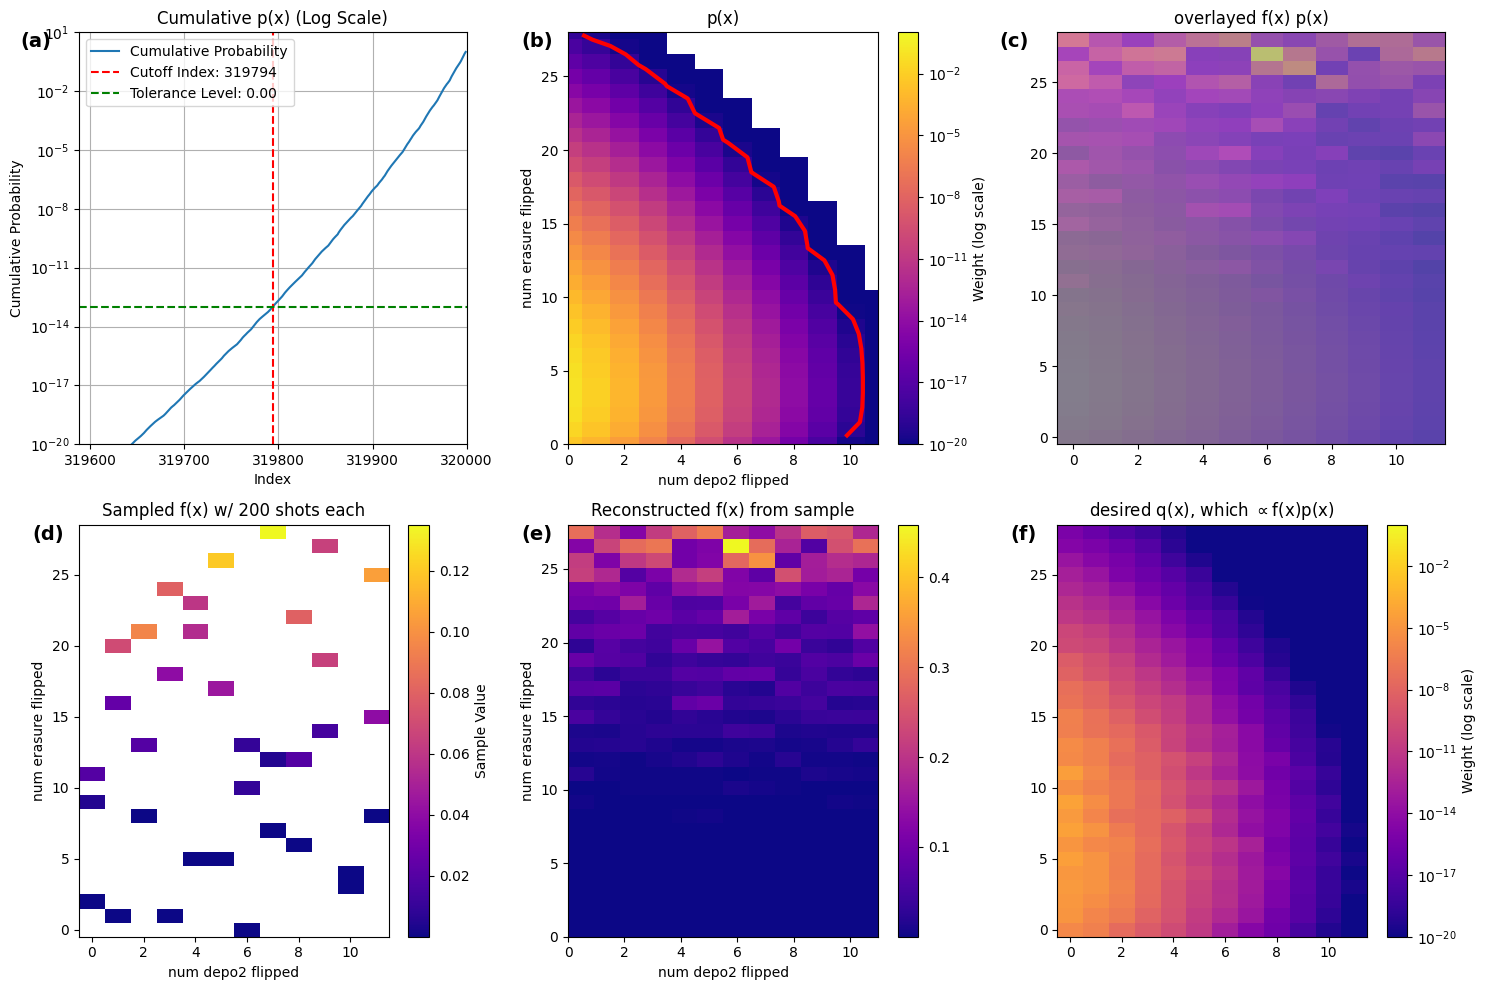

In [67]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.ticker as ticker

# Assuming the variables like cumulative_prob, cutoff_index, etc. are already defined

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 1 row, 4 columns

# First plot: Cumulative Probability Plot
axs[0,0].plot(cumulative_prob, label='Cumulative Probability')
axs[0,0].axvline(x=cutoff_index, color='r', linestyle='--', label=f'Cutoff Index: {cutoff_index}')
axs[0,0].axhline(y=p_tolerance, color='g', linestyle='--', label=f'Tolerance Level: {p_tolerance:.2f}')
axs[0,0].set_xlim(xmin=len(sorted_weights) - 2*(len(sorted_weights) - cutoff_index), xmax=len(sorted_weights))
axs[0,0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
axs[0,0].set_ylim(1e-20, 1e1)
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel('Index')
axs[0,0].set_ylabel('Cumulative Probability')
axs[0,0].set_title('Cumulative p(x) (Log Scale)')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot: Heatmap of Weights with Contour
im = axs[0,1].imshow(weights, norm=LogNorm(vmin=1e-20, vmax=1), origin='upper', cmap='plasma', aspect='auto')
fig.colorbar(im, ax=axs[0,1], label='Weight (log scale)')
contour_set = axs[0,1].contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
contour_path = contour_set.collections[0].get_paths()[0]
contour_coords = contour_path.vertices
x_coords = contour_coords[:, 0]
y_coords = contour_coords[:, 1]
x_min = np.floor(x_coords.min()).astype(int)
x_max = np.ceil(x_coords.max()).astype(int)
y_min = np.floor(y_coords.min()).astype(int)
y_max = np.ceil(y_coords.max()).astype(int)
axs[0,1].set_xlim(x_min, x_max)
axs[0,1].set_ylim(y_min, y_max)
axs[0,1].set_xlabel('num depo2 flipped')
axs[0,1].set_ylabel('num erasure flipped')
axs[0,1].set_title('p(x)')

# Third plot: Sampled Points Heatmap
x_indices = landscape.sampled_indices_unravelled[0]
y_indices = landscape.sampled_indices_unravelled[1]
heatmap = np.full((resolution[0], resolution[1]), np.nan)
for i, (x, y) in enumerate(zip(x_indices, y_indices)):
    heatmap[x, y] = landscape.sampled_landscape[i]
im3 = axs[1,0].imshow(10**(heatmap.T),
                    #   norm=LogNorm(vmin=1e-20, vmax=1), 
                      cmap='plasma', origin='lower', aspect='auto')
fig.colorbar(im3, ax=axs[1,0], label='Sample Value')
axs[1,0].set_title('Sampled f(x) w/ 200 shots each')
axs[1,0].set_xlabel('num depo2 flipped')
axs[1,0].set_ylabel('num erasure flipped')

# Fourth plot: Dense Landscape
landscape_dense = landscape.to_dense()
im4 = axs[1,1].imshow(
    10**(landscape_dense.landscape.to_numpy().T),
    extent=landscape_dense.param_bounds.flat,
    cmap='plasma',
    origin="lower",
    aspect='auto',
    interpolation="none",
    # norm=LogNorm(vmin=1e-20, vmax=1)
)
fig.colorbar(im4, ax=axs[1,1])
axs[1,1].set_title('Reconstructed f(x) from sample')
axs[1,1].set_xlabel('num depo2 flipped')
axs[1,1].set_ylabel('num erasure flipped')



y = np.linspace(y_min, y_max, y_max-y_min+1)
x = np.linspace(x_min, x_max, x_max -x_min+1)
X, Y = np.meshgrid(x, y)
axs[0,2].pcolormesh(X, Y, weights[y_min: y_max+1,x_min:x_max+1],norm=LogNorm(vmin=1e-20, vmax=1), shading='auto', cmap='plasma', alpha=0.5)
axs[0,2].pcolormesh(X, Y, 10**(landscape_dense.landscape.to_numpy().T), shading='auto', cmap='plasma', alpha=0.5)
axs[0,2].set_title('overlayed f(x) p(x)')


axs[1,2].pcolormesh(X, Y, weights[y_min: y_max+1,x_min:x_max+1]*10**(landscape_dense.landscape.to_numpy().T), norm=LogNorm(vmin=1e-20, vmax=1),shading='auto', cmap='plasma', alpha=1)
fig.colorbar(im, ax=axs[1,2], label='Weight (log scale)')
axs[1,2].set_title(r'desired q(x), which $\propto $f(x)p(x)')


labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.flat):
    label = labels[i]
    ax.text(-0.15, 1.0, f'({label})', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.show()

fig.savefig('compressed_sensing_for_importance_sampling_low_p_physical.pdf')